In [144]:
# Imports
from datetime import timedelta, date, datetime

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [145]:
# Reading the data
daily_df = pd.read_csv('data/clean_data/daily.csv').set_index('id')
daily_df.head()

,date,store_id,store_type,location_type,region_code,holiday,discount,orders,sales
id,,,,,,,,,
T1000001,2018-01-01,1,S1,L3,R1,1,1,9,7011.84
T1000002,2018-01-01,253,S4,L2,R1,1,1,60,51789.12
T1000003,2018-01-01,252,S3,L2,R1,1,1,42,36868.20
T1000004,2018-01-01,251,S2,L3,R1,1,1,23,19715.16
T1000005,2018-01-01,250,S2,L3,R4,1,1,62,45614.52


In [146]:
# prcoess time columns
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df['year'] = daily_df['date'].dt.year
daily_df['weekofyear'] = daily_df['date'].dt.isocalendar().week

In [147]:
# limit to 4 
# regions
weekly_df = daily_df.groupby(['year', 'weekofyear', 'region_code']).agg(
    sales=("sales", "sum"),
    orders=("orders", "sum"),
    discounts=("discount", "sum"),
    holidays=("holiday", "sum")
    ).reset_index()
weekly_df['week'] = weekly_df['year'].astype(str) + "-" + weekly_df['weekofyear'].astype(str)
weekly_df.head()

,year,weekofyear,region_code,sales,orders,discounts,holidays,week
0,2018,1,R1,52925573.22,73891,674,124,2018-1
1,2018,1,R2,41212947.18,53120,586,105,2018-1
2,2018,1,R3,33846983.79,42500,456,86,2018-1
3,2018,1,R4,19725848.31,24119,266,50,2018-1
4,2018,2,R1,42225337.95,62244,246,124,2018-2


In [148]:
weekly_df.week.nunique()

74

<Axes: xlabel='week', ylabel='sales'>

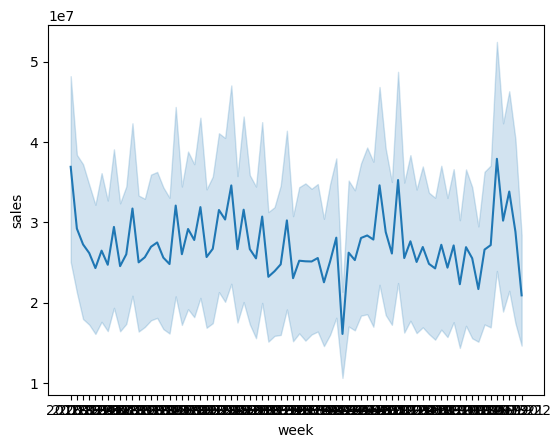

In [149]:
sns.lineplot(weekly_df, x="week", y="sales")

In [150]:
# stationary check
from statsmodels.tsa.stattools import adfuller
result = adfuller(weekly_df['sales'])
print('p-value: %f' % result[1])

p-value: 0.008739


In [151]:
# add lags
how_many_lags = 70 # 70/74 weeks 
lagged_df = weekly_df.copy()
for t in range(1, how_many_lags + 1):
    lagged_df[f'sales-{t}'] = lagged_df['sales'].shift(t)
print(lagged_df.shape)
lagged_df.head()

(296, 78)


,year,weekofyear,region_code,sales,orders,discounts,holidays,week,sales-1,sales-2,...,sales-61,sales-62,sales-63,sales-64,sales-65,sales-66,sales-67,sales-68,sales-69,sales-70
0,2018,1,R1,52925573.22,73891,674,124,2018-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,1,R2,41212947.18,53120,586,105,2018-1,52925573.22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,1,R3,33846983.79,42500,456,86,2018-1,41212947.18,52925573.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,1,R4,19725848.31,24119,266,50,2018-1,33846983.79,41212947.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,2,R1,42225337.95,62244,246,124,2018-2,19725848.31,33846983.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
# Dummify the region code feature
dummy = pd.get_dummies(lagged_df[['region_code']], drop_first=True)
lagged_df = pd.concat([lagged_df, dummy], axis=1)
lagged_df.head()

,year,weekofyear,region_code,sales,orders,discounts,holidays,week,sales-1,sales-2,...,sales-64,sales-65,sales-66,sales-67,sales-68,sales-69,sales-70,region_code_R2,region_code_R3,region_code_R4
0,2018,1,R1,52925573.22,73891,674,124,2018-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2018,1,R2,41212947.18,53120,586,105,2018-1,52925573.22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2,2018,1,R3,33846983.79,42500,456,86,2018-1,41212947.18,52925573.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
3,2018,1,R4,19725848.31,24119,266,50,2018-1,33846983.79,41212947.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
4,2018,2,R1,42225337.95,62244,246,124,2018-2,19725848.31,33846983.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [153]:
# Instantiate the model
lagged_df = lagged_df.iloc[how_many_lags:, :]
features = [f"sales-{t}" for t in range(1, how_many_lags + 1)] + \
    ["holidays", "discounts"] + \
    [f"region_code_R{r}" for  r in range(2,5)]


In [154]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(lagged_df[features], lagged_df['sales'], test_size=0.2, random_state=42, shuffle=False)

In [155]:
lr = LinearRegression()
lr.fit(X=lagged_df[features], y=lagged_df['sales'])
print(list(zip(lr.feature_names_in_, lr.coef_)))
print(lr.intercept_)

[('sales-1', 0.28813921120842667), ('sales-2', 0.19648620264838634), ('sales-3', -0.12283825050974698), ('sales-4', 0.1423072710893039), ('sales-5', 0.0776095951827584), ('sales-6', 0.04012729536911391), ('sales-7', -0.04621769750880589), ('sales-8', 0.18716529130988116), ('sales-9', -0.09199578527241031), ('sales-10', -0.06953779691526299), ('sales-11', 0.03636508909416586), ('sales-12', -0.03321672650750799), ('sales-13', -0.043615981778390905), ('sales-14', -0.09322713680308731), ('sales-15', 0.0466757019313632), ('sales-16', -0.14622134487669597), ('sales-17', 0.00792223663146252), ('sales-18', 0.04300514030513729), ('sales-19', -0.02001872769121947), ('sales-20', -0.1299542374737923), ('sales-21', -0.006369619365976159), ('sales-22', 0.03227572742383278), ('sales-23', 0.010676073471632228), ('sales-24', -0.08801394365096915), ('sales-25', 0.08672076838310122), ('sales-26', 0.03916257393527272), ('sales-27', 0.028542759515041455), ('sales-28', 0.11776325658507877), ('sales-29', 0.0

In [156]:
lagged_df.tail()

,year,weekofyear,region_code,sales,orders,discounts,holidays,week,sales-1,sales-2,...,sales-64,sales-65,sales-66,sales-67,sales-68,sales-69,sales-70,region_code_R2,region_code_R3,region_code_R4
291,2019,21,R4,14438613.00,20193,131,0,2019-21,26504508.00,30914343.00,...,12571476.00,22637694.00,27237792.00,37917576.00,14002265.58,26057481.15,29104483.41,0,0,1
292,2019,22,R1,31535552.10,49918,313,124,2019-22,14438613.00,26504508.00,...,40974889.56,12571476.00,22637694.00,27237792.00,37917576.00,14002265.58,26057481.15,0,0,0
293,2019,22,R2,22791390.48,33249,302,105,2019-22,31535552.10,14438613.00,...,28876288.86,40974889.56,12571476.00,22637694.00,27237792.00,37917576.00,14002265.58,1,0,0
294,2019,22,R3,19132778.37,27089,217,86,2019-22,22791390.48,31535552.10,...,24966169.89,28876288.86,40974889.56,12571476.00,22637694.00,27237792.00,37917576.00,0,1,0
295,2019,22,R4,10286828.04,14342,116,50,2019-22,19132778.37,22791390.48,...,12982991.70,24966169.89,28876288.86,40974889.56,12571476.00,22637694.00,27237792.00,0,0,1


In [157]:
def linear_model_builder(df, lags):
    models = []
    # Engineered Feature
    df['o2'] = df['orders'] ** 2
    
    for r_val in df['region_code'].unique():
        # creates a df for each region with weeks in order
        regional_df = df[df['region_code'] == r_val].copy()
        
        # Build lagged features
        for t in range(1, lags + 1):
            regional_df[f'sales-{t}'] = regional_df['sales'].shift(t)
        
        lagged_df = regional_df.iloc[lags:, :]
        features = [f"sales-{t}" for t in range(1, lags + 1)] + \
            ["holidays", "discounts", "year", 'orders', 'o2']
            
        Xtrain, Xtest, ytrain, ytest = \
                            train_test_split(lagged_df[features], 
                                            lagged_df['sales'],
                                            test_size=0.2,
                                            random_state=42,
                                            shuffle=False)                    
        lr = LinearRegression()
        lr.fit(X=Xtrain, y=ytrain)
        print(f"""
        Region: {r_val} with lag = {lags}, rows: {lagged_df.shape[0]}
        ________________________________________________________
        Train R2: {lr.score(Xtrain, ytrain):.3f}%, Train RMSE: {np.sqrt(mean_squared_error(ytrain, lr.predict(Xtrain))):.0f}
        Test R2: {lr.score(Xtest, ytest):.3f}%, Test RMSE: {np.sqrt(mean_squared_error(ytest, lr.predict(Xtest))):.0f}
        Mean of sales: {lagged_df['sales'].mean():.2f}
        Test RMSE as % of mean of sales: {np.sqrt(mean_squared_error(ytest, lr.predict(Xtest))) / lagged_df['sales'].mean():.5f}%
        """, end="")
        models.append(lr)
    return models
        

In [168]:
models = linear_model_builder(weekly_df, 3)


        Region: R1 with lag = 3, rows: 71
        ________________________________________________________
        Train R2: 0.768%, Train RMSE: 2402897
        Test R2: 0.949%, Test RMSE: 1523600
        Mean of sales: 40244687.30
        Test RMSE as % of mean of sales: 0.03786%
        
        Region: R2 with lag = 3, rows: 71
        ________________________________________________________
        Train R2: 0.753%, Train RMSE: 1650996
        Test R2: 0.921%, Test RMSE: 1108034
        Mean of sales: 29113296.74
        Test RMSE as % of mean of sales: 0.03806%
        
        Region: R3 with lag = 3, rows: 71
        ________________________________________________________
        Train R2: 0.791%, Train RMSE: 1496516
        Test R2: 0.954%, Test RMSE: 960723
        Mean of sales: 25124645.94
        Test RMSE as % of mean of sales: 0.03824%
        
        Region: R4 with lag = 3, rows: 71
        ________________________________________________________
        Train R2: 0.